In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import fileinput
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import csv
import random

# Junctions with spiked behaviour in C-Town with MiniCPS. 
We will be using the week_0 of the 30 weeks c-town simulation as the test week. A first approach is to compare the results of the simulation using stand-alone WNTR and WNTR with WNTR with MiniCPS. 

In [12]:
# We load the csv files with the initial conditions
path_prefix = "../../../Demand_patterns/"
week_index = 0

total_demands = pd.read_csv(path_prefix+ 'three_year_demands_ctown.csv', index_col=0)
demand_starting_points = pd.read_csv(path_prefix+ 'starting_demand_points.csv', index_col=0)
initial_tank_levels = pd.read_csv(path_prefix + 'tank_initial_conditions.csv', index_col=0)

In [18]:
# We load the base C-Town .inp file with controls and create a water network model using the .inp file
# load EPANET model
inp_file = path_prefix + 'ctown_map_with_controls.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Replace the demand patterns with the random patterns for week 0
week_index = 0
week_start = demand_starting_points.iloc[week_index][0]
week_demands = total_demands.loc[week_start:week_start+240:]

names, patterns =[],[]
for name, pat in wn.patterns():  
    pat.multipliers = week_demands[name].values.tolist()

# Replace the initial tank levels with the values stored in the .csv file for week 0
for i in range(1,8):    
    wn.get_node('T' + str(i)).init_level = float(initial_tank_levels.iloc[week_index]['T'+ str(i)])

# We create a new .inp file for C-Town, with the conditions of week 0
# WARNING. There seems to be a bug into the WNTR modue that screws the controls if we write the file. We gotta copy the controls from the original c-town file
wn.write_inpfile('ctown_year_simulation_week_0.inp')

In [19]:
# load EPANET model
inp_file = 'ctown_year_simulation_week_0.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.time.duration = wn.options.time.duration

In [15]:
wn.options.time.duration

864000

In [16]:
wn.options.time.hydraulic_timestep

300

In [20]:
# Simulate hydraulics. Store the pressure results of all nodes into a .csv file
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_new = sim.run_sim()
pressure_results = results_new.node['pressure']
pressure_results.to_csv('data/test_ctown_week_0_wntr.csv')

In [23]:
results_new.link['flowrate'].to_csv('data/flows_test_ctown_week_0_wntr.csv')
results_new.link['status'].to_csv('data/status_test_ctown_week_0_wntr.csv')

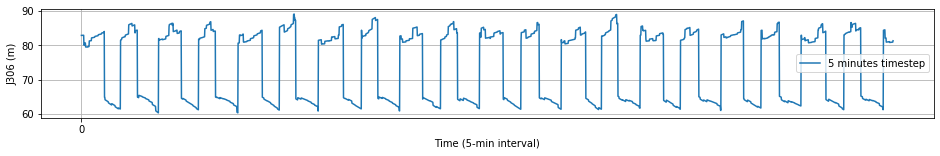

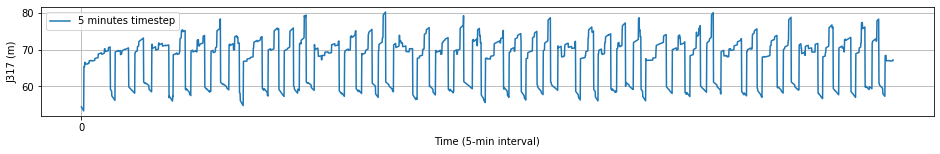

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'   
    
path_in = 'data/'

sim_weeks = 1

# Data frame creation                
data_5_timestep = pd.read_csv('data/test_ctown_week_0_wntr.csv')    

#////////////////////////////// label, cat/non-cat variable definition     ///////////////////////////////

var_all = list(data_5_timestep.head(0))
#var_noncat = ['T1_LEVEL', 'T2_LEVEL', 'T3_LEVEL', 'T4_LEVEL', 'T5_LEVEL', 'T6_LEVEL', 'T7_LEVEL', 
#               'PU1_FLOW', 'PU2_FLOW', 'PU3_FLOW', 'PU4_FLOW', 'PU5_FLOW', 'PU6_FLOW', 'PU7_FLOW',
#               'PU8_FLOW', 'PU9_FLOW', 'PU10_FLOW', 'PU11_FLOW', 
#               'V2_FLOW', 
#               'J280_LEVEL', 'J269_LEVEL', 'J300_LEVEL', 'J256_LEVEL', 'J289_LEVEL', 'J415_LEVEL', 
#               'J302_LEVEL', 'J306_LEVEL', 'J307_LEVEL', 'J317_LEVEL', 'J14_LEVEL', 'J422_LEVEL']      
    
#var_cat =['PU1_STATUS', 'PU2_STATUS', 'PU3_STATUS', 'PU4_STATUS', 'PU5_STATUS', 'PU6_STATUS', 'PU7_STATUS', 'PU8_STATUS',
#          'PU9_STATUS','PU10_STATUS', 'PU11_STATUS',
#          'V2_STATUS'] 

#var_cat_noncat = var_noncat + var_cat
var_cat_noncat =['J306', 'J317']


label = ['Attack#01', 'Attack#02']


tanks = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

joints = ['J280', 'J269', 'J300', 'J256', 'J289', 'J415',
          'J302', 'J306', 'J307', 'J317', 'J14', 'J422']

xlabel_weeks = np.linspace(0, len(data_5_timestep), sim_weeks)
        
for var in (var_cat_noncat):
    plt.figure(figsize=(16, 2))    
    plt.plot(data_5_timestep[var], label="5 minutes timestep")
    plt.legend()
    plt.grid(True)
    
    if var in tanks:
        plt.ylabel(var + ' (m)')
    elif var in joints:
        plt.ylabel(var + ' (m)')
    elif var in flows:
        plt.ylabel(var + ' (L/S)')
    else:
        plt.ylabel(var)
        
    plt.xlabel('Time (5-min interval)')
    plt.xticks(xlabel_weeks), #plt.xlabel(label_x)
    plt.show()

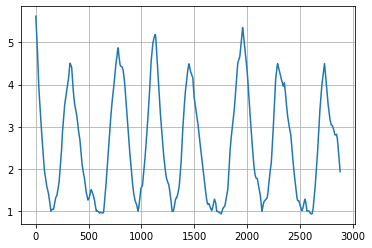

In [6]:
plt.plot(data_5_timestep['T1'], label="T1 Level")
plt.grid()

In [8]:
print(data_5_timestep['T1'].iloc[0])
print(data_5_timestep['T2'].iloc[0])
print(data_5_timestep['T3'].iloc[0])

5.622006329100003
1.3737812430999978
2.1098712997000035


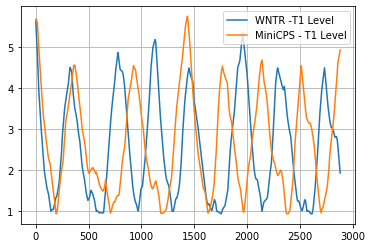

In [10]:
wntr_only = pd.read_csv('data/test_ctown_week_0_wntr.csv') 
minicps = pd.read_csv('data/week_0_5_minute_timestep/physical_process.csv')
plt.plot(wntr_only['T1'], label="WNTR -T1 Level")
plt.plot(minicps['T1_LEVEL'], label="MiniCPS - T1 Level")
plt.grid()
plt.legend()

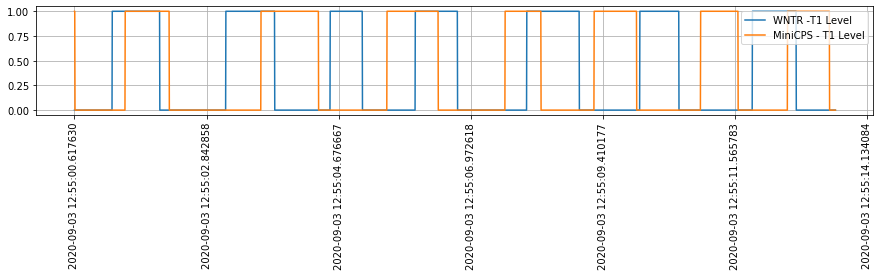

In [41]:
plt.figure(figsize=(15,2))
plt.plot(results_new.link['status'].reset_index()['PU2'], label="WNTR -T1 Level")
plt.plot(minicps.reset_index()['PU2_STATUS'], label="MiniCPS - T1 Level")
plt.grid()
plt.legend()
plt.gca().set_xticklabels(minicps.Timestamps.to_list(), rotation=90);

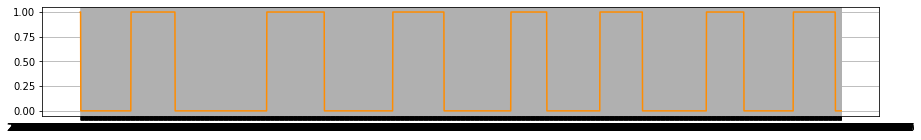

In [50]:
plt.figure(figsize=(15,2))
plt.plot(minicps['Timestamps'],minicps['PU2_STATUS'], c='darkorange')
plt.grid()

Using WNTR in standalone, there is no presence of spikes in the junctions